In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache      # install this via 'pip install -U git+https://github.com/alleninstitute/abc_atlas_access'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versi

In [2]:
download_base = Path('./Zhuang')        # Choose the local directory to which data files will be downloaded.
abc_cache = AbcProjectCache.from_cache_dir(download_base)

dataset = 'Zhuang-ABCA-1'

# Retrieves cell metadata file; downloads if not in local directory
cells = abc_cache.get_metadata_dataframe(directory=dataset, file_name='cell_metadata', dtype={'cell_label': str})
cells.set_index('cell_label', inplace=True)

# Retrieves CCF coordinates for the cells; downloads if not in local directory
ccf_coordinates = abc_cache.get_metadata_dataframe(directory=f'{dataset}-CCF', file_name='ccf_coordinates')
ccf_coordinates.set_index('cell_label', inplace=True)
ccf_coordinates.rename(columns={'x': 'CCF_x', 'y': 'CCF_y', 'z': 'CCF_z'}, inplace=True)

# Appends CCF coordinates to the cell metadata
cells = cells.join(ccf_coordinates, how='inner').rename(columns={'x_ccf': 'CCF_x', 'y_ccf': 'CCF_y', 'z_ccf': 'CCF_z', 'parcellation_index': 'CCF_parcellation_index'})
cells['y'] = -cells['y']

# Retrieves parcellation information; downloads if not in local directory
parcellation_annotation = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020', file_name='parcellation_to_parcellation_term_membership')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/abc_atlas_access/abc_atlas_cache/cloud_cache.py:630: OutdatedManifestWarning: You are loading releases/20241130/manifest.json. A more up to date version of the dataset -- releases/20250531/manifest.json -- exists online. To see the changes between the two versions of the dataset, run
type.compare_manifests('releases/20241130/manifest.json', 'releases/20250531/manifest.json')
To load another version of the dataset, run
type.load_manifest('releases/20250531/manifest.json')
  warnings.warn(msg, OutdatedManifestWarning)


In [7]:
# Functions to determine lateral borders of columns, and to extract layer identities of columnar cells
def leftFunc(x, borders):
    [[x1, x2], [y1, y2]] = borders[0]
    return (y1 - y2) / (x1 - x2) * (x - x1) + y1

def rightFunc(x, borders):
    [[x1, x2], [y1, y2]] = borders[1]
    return (y1 - y2) / (x1 - x2) * (x - x1) + y1

# Gets cells within the specified region
def cells_of(cells, cells_by_regions, region):
    return cells[cells.index.isin(cells_by_regions[cells_by_regions[region] == True].index)]

'''
Each parcellation term corresponds to an 'order' in the parcellation hierarchy, where higher-order terms are more specific subsets of lower-order terms
The dictionary maps each region of interest to a string portion of its parcellation term name, as well as the order in which to look for that name.
'''
name_map = {'Isocortex': ['isocortex', 2],
            'SOM': ['somatosensory', 3],
            'AUD': ['auditory', 3],
            'layer 1': ['layer 1', 4],
            'layer 2/3': ['layer 2/3', 4],
            'layer 4': ['layer 4', 4],
            'layer 5': ['layer 5', 4],
            'layer 6': ['layer 6', 4],}

layers = ['layer 2/3', 'layer 4', 'layer 5', 'layer 6']

# Outputs layer-specific cell counts for the specified region
def get_counts(slice, borders, name='ROI'):
    roi_cells = cells[cells['brain_section_label'] == 'Zhuang-ABCA-'+str(slice)]
    roi_cells_by_regions = pd.DataFrame(index=roi_cells.index, columns=name_map.keys()).fillna(False)
    
    # Iterates through each cell and each region, and identifies if the cell's parcellation index falls under the region's parcellation ancestry
    for cell in roi_cells.index:
        for region, [search, order] in name_map.items():
            roi_cells_by_regions.loc[cell, region] = search in list(parcellation_annotation[parcellation_annotation['parcellation_index'] == roi_cells.loc[cell, 'CCF_parcellation_index']]['parcellation_term_name'])[order].lower()
    
    # Plot the isocortex as background
    isocortex = roi_cells[roi_cells.index.isin(roi_cells_by_regions[roi_cells_by_regions['Isocortex'] == True].index)]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')
    ax.plot(isocortex['x'], isocortex['y'], 'ok', ms=1, alpha=0.3)
    
    # Get counts of isocortex without L1
    iso_no_l1 = roi_cells[roi_cells.index.isin(roi_cells_by_regions[(roi_cells_by_regions['Isocortex'] == True) & (roi_cells_by_regions['layer 1'] == False)].index)]
    column = iso_no_l1[(iso_no_l1['y'] > leftFunc(iso_no_l1['x'], borders)) & (iso_no_l1['y'] < rightFunc(iso_no_l1['x'], borders))]
    print(len(column), 'Isocortex')

    # Get counts of each individual layer in ROI
    for layer in layers:
        region = cells_of(roi_cells, roi_cells_by_regions, layer)
        column = region[(region['y'] > leftFunc(region['x'], borders)) & (region['y'] < rightFunc(region['x'], borders))]
        print(len(column), layer)
        ax.plot(column['x'], column['y'], 'o', ms=1, alpha=0.8, label=layer)
    
    # Plot layers of ROI
    ax.set_title(str(name) + ' column from ABCA-1 slice ' + str(slice))
    ax.legend(loc='lower right')
    plt.show()



1237 Isocortex
331 layer 2/3
275 layer 4
190 layer 5
441 layer 6


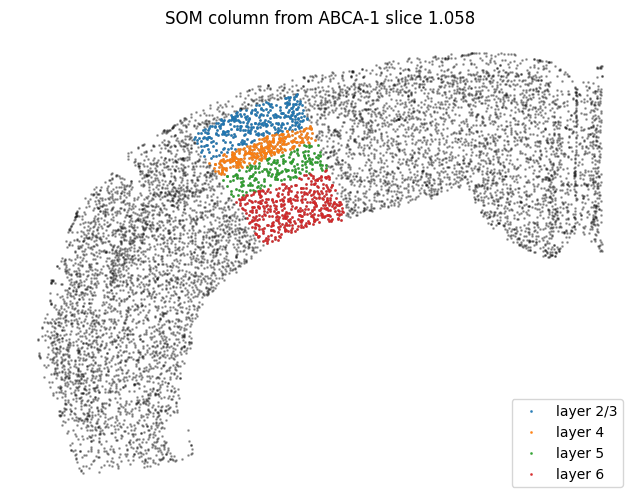

In [8]:
som_borders = np.array([[[3.163749883786499, 2.481411543681871], 
                         [-2.984381204079216, -1.920129826905108]],
                         
                         [[3.846496599697873, 3.402327776942732],
                          [-2.7383452452886643, -1.5781737284616928]]])

get_counts(1.058, som_borders, name='SOM')